Market Segmentation (Note: Run Data Cleaning Notebook First)
===================

Importing Libraries and Reading Data

In [1]:
! pip install -r requirements.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import seaborn as sns


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
df = pd.read_csv('trips_2018_cleaned.csv')
print(df.columns)
df.head()

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_latitude', 'start_station_longitude', 'end_station_id',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'birth_year', 'gender', 'calculated_duration', 'date', 'hour',
       'day_of_week', 'month', 'week'],
      dtype='object')


tripduration                starttime                 stoptime  \
0           970  2018-01-01 13:50:57.434  2018-01-01 14:07:08.186   
1           723  2018-01-01 15:33:30.182  2018-01-01 15:45:33.341   
2           496  2018-01-01 15:39:18.337  2018-01-01 15:47:35.172   
3           306  2018-01-01 15:40:13.372  2018-01-01 15:45:20.191   
4           306  2018-01-01 18:14:51.568  2018-01-01 18:19:57.642   

   start_station_id  start_station_latitude  start_station_longitude  \
0                72               40.767272               -73.993929   
1                72               40.767272               -73.993929   
2                72               40.767272               -73.993929   
3                72               40.767272               -73.993929   
4                72               40.767272               -73.993929   

   end_station_id  end_station_latitude  end_station_longitude  bikeid  \
0             505             40.749013             -73.988484   31956   
1            3255             40.750585             -73.994685   32536   
2             525             40.755942             -74.002116   16069   
3             447             40.763707             -73.985162   31781   
4            3356             40.774667             -73.984706   30319   

     usertype  birth_year  gender  calculated_duration        date  hour  \
0  Subscriber        1992       1              970.752  2018-01-01    13   
1  Subscriber        1969       1              723.159  2018-01-01    15   
2  Subscriber        1956       1              496.835  2018-01-01    15   
3  Subscriber        1974       1              306.819  2018-01-01    15   
4  Subscriber        1992       1              306.074  2018-01-01    18   

  day_of_week  month  week  
0      Monday      1     1  
1      Monday      1     1  
2      Monday      1     1  
3      Monday      1     1  
4      Monday      1     1

Make a separate datafram for station data

In [3]:
stations = pd.DataFrame(columns=["id", "latitude", "longitude"])
stations[["id", "latitude", "longitude"]] = df[
    ["start_station_id", "start_station_latitude", "start_station_longitude"]
]

stations = pd.concat(
    [
        stations,
        df[["end_station_id", "end_station_latitude", "end_station_longitude"]].rename(
            columns={
                "end_station_id": "id",
                "end_station_latitude": "latitude",
                "end_station_longitude": "longitude",
            }
        ),
    ],
    ignore_index=True,
)

stations.drop_duplicates(inplace=True)
stations.reset_index(drop=True, inplace=True)

stations

id   latitude  longitude
0      72  40.767272 -73.993929
1      79  40.719116 -74.006667
2      82  40.711174 -74.000165
3      83  40.683826 -73.976323
4     119  40.696089 -73.978034
..    ...        ...        ...
840  3195  40.730743 -74.063784
841  3187  40.721124 -74.038051
842  3639  40.719252 -74.034234
843  3277  40.714358 -74.066611
844  3279  40.721630 -74.049968

[845 rows x 3 columns]

Get demand and supply for each station

In [4]:
start_stations = df.groupby("start_station_id").size().reset_index(name="start_count")
end_stations = df.groupby("end_station_id").size().reset_index(name="end_count")

stations = pd.merge(
    stations, start_stations, how="left", left_on="id", right_on="start_station_id"
)
stations = pd.merge(
    stations, end_stations, how="left", left_on="id", right_on="end_station_id"
)

stations.fillna(0, inplace=True)


# to int
stations["start_count"] = stations["start_count"].astype(int)
stations["end_count"] = stations["end_count"].astype(int)

stations["total_demand"] = stations["start_count"] - stations["end_count"]
stations["frequency"] = stations["start_count"] + stations["end_count"]
stations["total_demand_type"] = stations["total_demand"].apply(
    lambda x: "Positive" if x > 0 else "Equal" if x == 0 else "Negative"
)

Do the same again but split by before and after noon

In [5]:


# before noon and after noon
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

before_noon_start_stations = (
    df[(df["starttime"].dt.hour < 12)]
    .groupby("start_station_id")
    .size()
    .reset_index(name="before_noon_start_count")
)
after_noon_start_stations = (
    df[(df["starttime"].dt.hour >= 12)]
    .groupby("start_station_id")
    .size()
    .reset_index(name="after_noon_start_count")
)

before_noon_end_stations = (
    df[(df["stoptime"].dt.hour < 12)]
    .groupby("end_station_id")
    .size()
    .reset_index(name="before_noon_end_count")
)
after_noon_end_stations = (
    df[(df["stoptime"].dt.hour >= 12)]
    .groupby("end_station_id")
    .size()
    .reset_index(name="after_noon_end_count")
)

stations = pd.merge(
    stations,
    before_noon_start_stations,
    how="left",
    left_on="id",
    right_on="start_station_id",
)
stations = pd.merge(
    stations,
    after_noon_start_stations,
    how="left",
    left_on="id",
    right_on="start_station_id",
)
stations = pd.merge(
    stations,
    before_noon_end_stations,
    how="left",
    left_on="id",
    right_on="end_station_id",
)
stations = pd.merge(
    stations,
    after_noon_end_stations,
    how="left",
    left_on="id",
    right_on="end_station_id",
)


stations.fillna(0, inplace=True)

# to int
stations["before_noon_start_count"] = stations["before_noon_start_count"].astype(int)
stations["after_noon_start_count"] = stations["after_noon_start_count"].astype(int)
stations["before_noon_end_count"] = stations["before_noon_end_count"].astype(int)
stations["after_noon_end_count"] = stations["after_noon_end_count"].astype(int)


stations["before_noon_demand"] = (
    stations["before_noon_start_count"] - stations["before_noon_end_count"]
)
stations["total_demand_type"] = stations["total_demand"].apply(
    lambda x: "Positive" if x > 0 else "Equal" if x == 0 else "Negative"
)
stations["before_noon_demand_type"] = stations["before_noon_demand"].apply(
    lambda x: "Positive" if x > 0 else "Equal" if x == 0 else "Negative"
)
stations["after_noon_demand"] = (
    stations["after_noon_start_count"] - stations["after_noon_end_count"]
)
stations["after_noon_demand_type"] = stations["after_noon_demand"].apply(
    lambda x: "Positive" if x > 0 else "Equal" if x == 0 else "Negative"
)


Drop unnecessary columns

In [6]:
stations.drop(
    columns=[
        "start_station_id",
        "end_station_id",
        "start_station_id_x",
        "end_station_id_x",
        "start_station_id_y",
        "end_station_id_y",
    ],
    inplace=True,
)

Plotting the stations on a map, colored by net demand type and sized by net demand

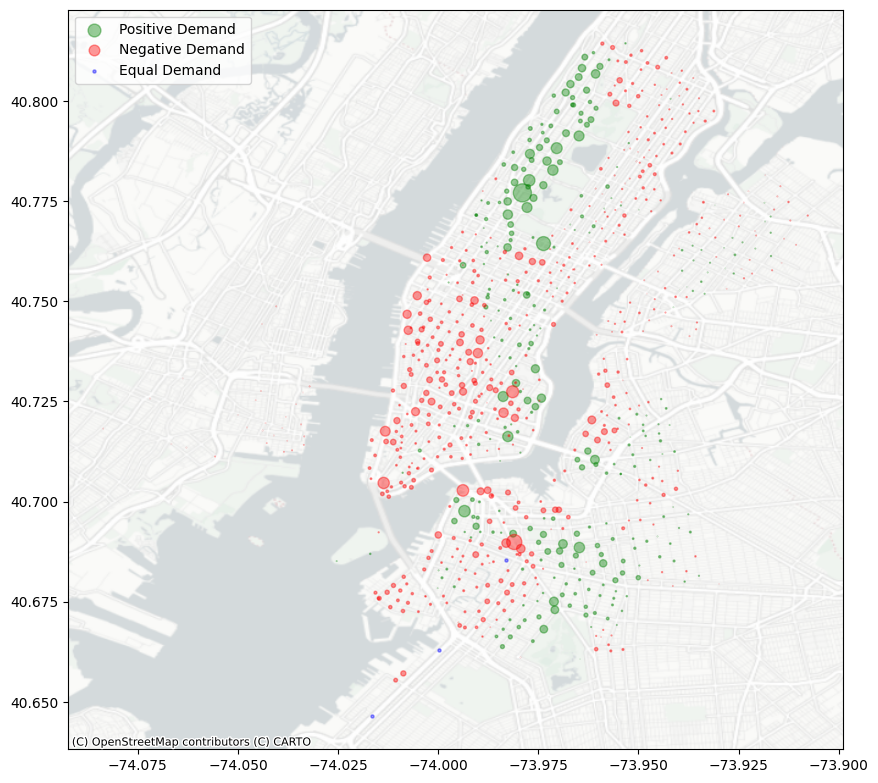

In [7]:

#plot stations on map
gdf_stations = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude))

gdf_stations.set_crs(epsg=4326, inplace=True)

fig,ax=plt.subplots(figsize=(10,10))

gdf_stations[gdf_stations['total_demand_type']=="Positive"].plot(ax=ax,markersize=gdf_stations[gdf_stations['total_demand_type']=="Positive"]['total_demand'].to_numpy()/100, alpha=0.4,color="green", label="Positive Demand", aspect='equal')
gdf_stations[gdf_stations['total_demand_type']=="Negative"].plot(ax=ax,markersize=-1*gdf_stations[gdf_stations['total_demand_type']=="Negative"]['total_demand'].to_numpy()/100, alpha=0.4,color="red", label="Negative Demand", aspect='equal')
gdf_stations[gdf_stations['total_demand_type']=="Equal"].plot(ax=ax,markersize=5, alpha=0.4,color="blue", label="Equal Demand", aspect='equal')

cx.add_basemap(ax, zoom=12, crs=gdf_stations.crs.to_string(),source=cx.providers.CartoDB.PositronNoLabels)
plt.legend()


Plotting the stations on a map, colored by before noon net demand type and sized by before noon net demand

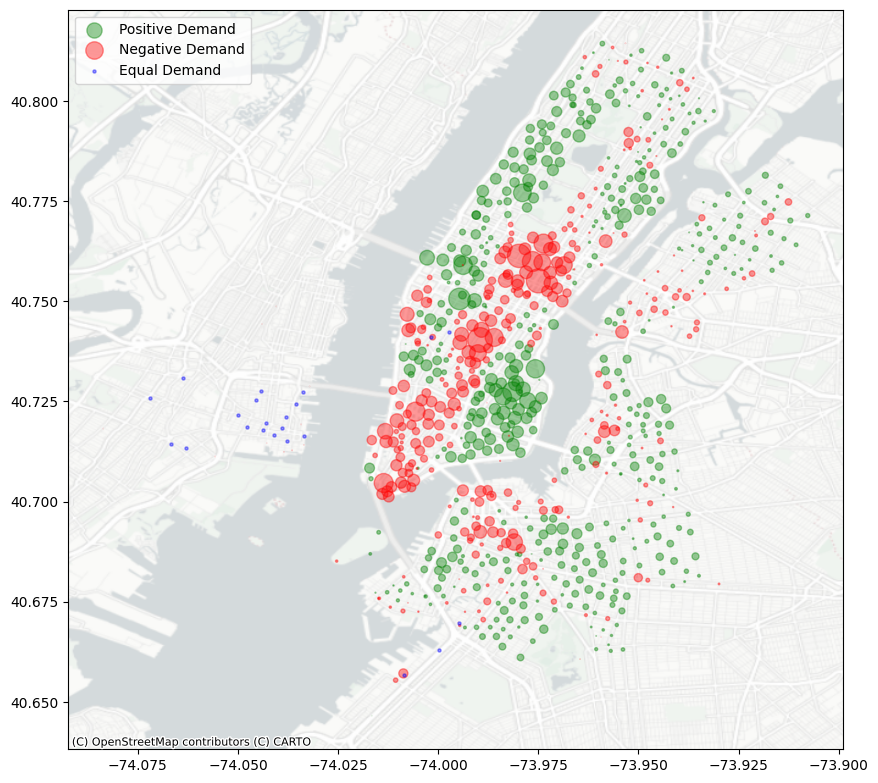

In [8]:
# before noon
fig,ax=plt.subplots(figsize=(10,10))
gdf_stations[gdf_stations['before_noon_demand_type']=="Positive"].plot(ax=ax,markersize=gdf_stations[gdf_stations['before_noon_demand_type']=="Positive"]['before_noon_demand'].to_numpy()/100, alpha=0.4,color="green", label="Positive Demand", aspect='equal')
gdf_stations[gdf_stations['before_noon_demand_type']=="Negative"].plot(ax=ax,markersize=-1*gdf_stations[gdf_stations['before_noon_demand_type']=="Negative"]['before_noon_demand'].to_numpy()/100, alpha=0.4,color="red", label="Negative Demand", aspect='equal')
gdf_stations[gdf_stations['before_noon_demand_type']=="Equal"].plot(ax=ax,markersize=5, alpha=0.4,color="blue", label="Equal Demand", aspect='equal')

cx.add_basemap(ax, zoom=12, crs=gdf_stations.crs.to_string(),source=cx.providers.CartoDB.PositronNoLabels)
plt.legend()

Plotting the stations on a map, colored by after noon net demand type and sized by after noon net demand

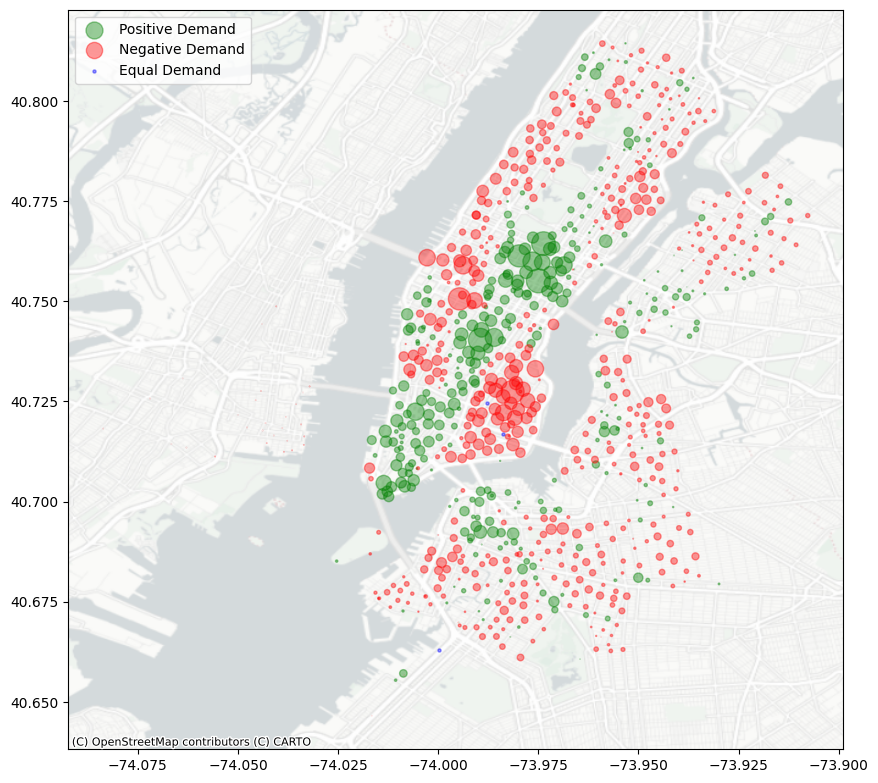

In [9]:
fig,ax=plt.subplots(figsize=(10,10))
gdf_stations[gdf_stations['after_noon_demand_type']=="Positive"].plot(ax=ax,markersize=gdf_stations[gdf_stations['after_noon_demand_type']=="Positive"]['after_noon_demand'].to_numpy()/100, alpha=0.4,color="green", label="Positive Demand", aspect='equal')
gdf_stations[gdf_stations['after_noon_demand_type']=="Negative"].plot(ax=ax,markersize=-1*gdf_stations[gdf_stations['after_noon_demand_type']=="Negative"]['after_noon_demand'].to_numpy()/100, alpha=0.4,color="red", label="Negative Demand", aspect='equal')
gdf_stations[gdf_stations['after_noon_demand_type']=="Equal"].plot(ax=ax,markersize=5, alpha=0.4,color="blue", label="Equal Demand", aspect='equal')

cx.add_basemap(ax, zoom=12, crs=gdf_stations.crs.to_string(),source=cx.providers.CartoDB.PositronNoLabels)
plt.legend()

Box Plots showing the distributions of net demand in total, before noon, and after noon

C:\Users\anton\AppData\Local\Temp\ipykernel_30624\571175673.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plots, labels=["Net Demand", "Before Noon Net Demand", "After Noon Net Demand"])


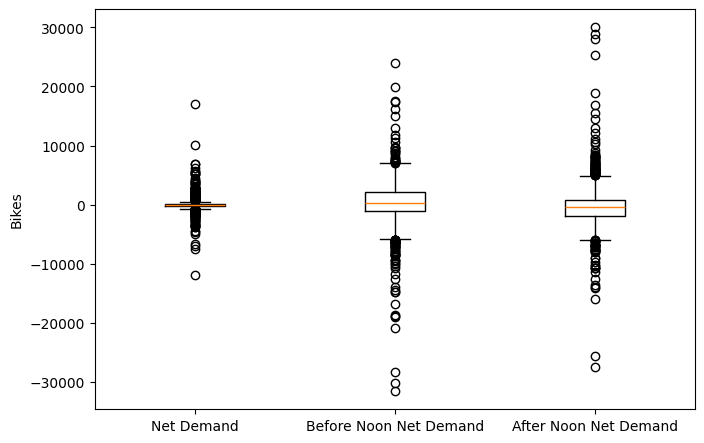

In [10]:
# boxplots of before noon and after noon demand

plots = [stations["total_demand"],stations["before_noon_demand"], stations["after_noon_demand"]]

fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(plots, labels=["Net Demand", "Before Noon Net Demand", "After Noon Net Demand"])
plt.ylabel("Bikes")
plt.show()


Plotting the few stations that do not have opposite net demand types before and after noon

With sizes proportional to the absolute value of their net demand

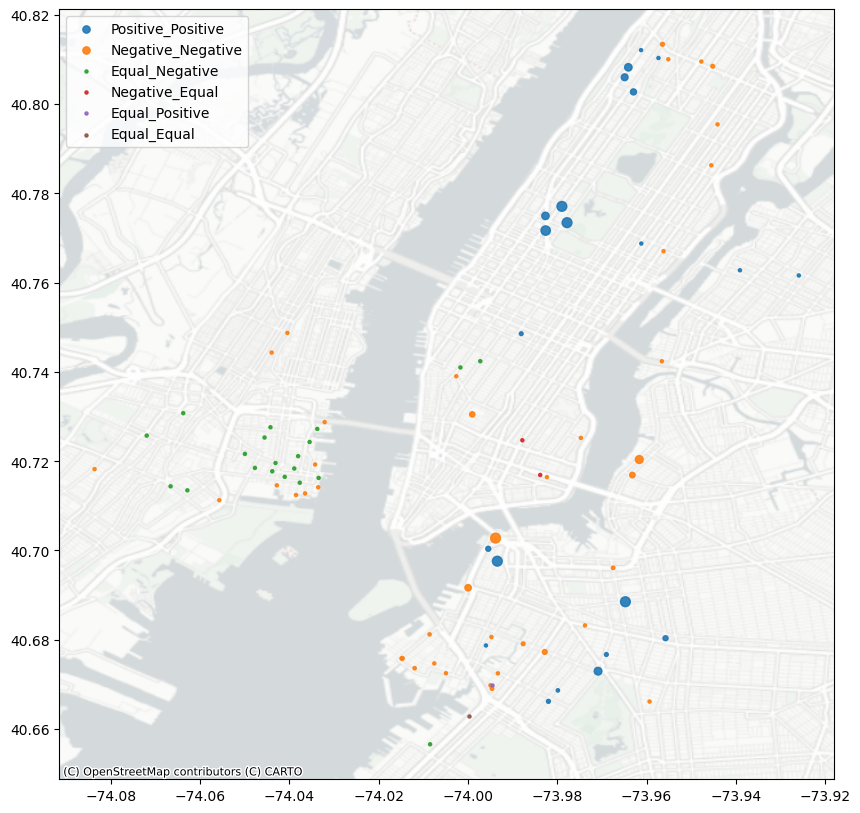

In [11]:
gdf_stations["full_demand_type"] = gdf_stations["before_noon_demand_type"] + "_" + gdf_stations["after_noon_demand_type"]

# plot with color for each full_demand_type
fig,ax=plt.subplots(figsize=(10,10))
for demand_type in gdf_stations['full_demand_type'].unique():
    if demand_type not in ["Positive_Negative", "Negative_Positive"]:
        gdf_stations[gdf_stations['full_demand_type']==demand_type].plot(
            ax=ax,
            markersize=np.clip(np.abs(gdf_stations[gdf_stations['full_demand_type']==demand_type]['total_demand'].to_numpy())/100, 5, 50),
            alpha=0.9,
            label=demand_type,
            aspect='equal'
        )

cx.add_basemap(ax, zoom=12, crs=gdf_stations.crs.to_string(),source=cx.providers.CartoDB.PositronNoLabels)

plt.legend()
fig.savefig('weird stations.png')

Making a table counting the demand type combinations, and how many stations fall into each combination

In [12]:
type_count = gdf_stations['full_demand_type'].value_counts()
print(type_count.to_latex())

\begin{tabular}{lr}
\toprule
 & count \\
full_demand_type &  \\
\midrule
Positive_Negative & 470 \\
Negative_Positive & 288 \\
Negative_Negative & 41 \\
Positive_Positive & 22 \\
Equal_Negative & 20 \\
Negative_Equal & 2 \\
Equal_Positive & 1 \\
Equal_Equal & 1 \\
\bottomrule
\end{tabular}



Now we can see that the majority of stations have opposite net demand types before and after noon, indicating a commuting pattern. 

This we will investigate further by first mapping the stations according to these to net demand types.

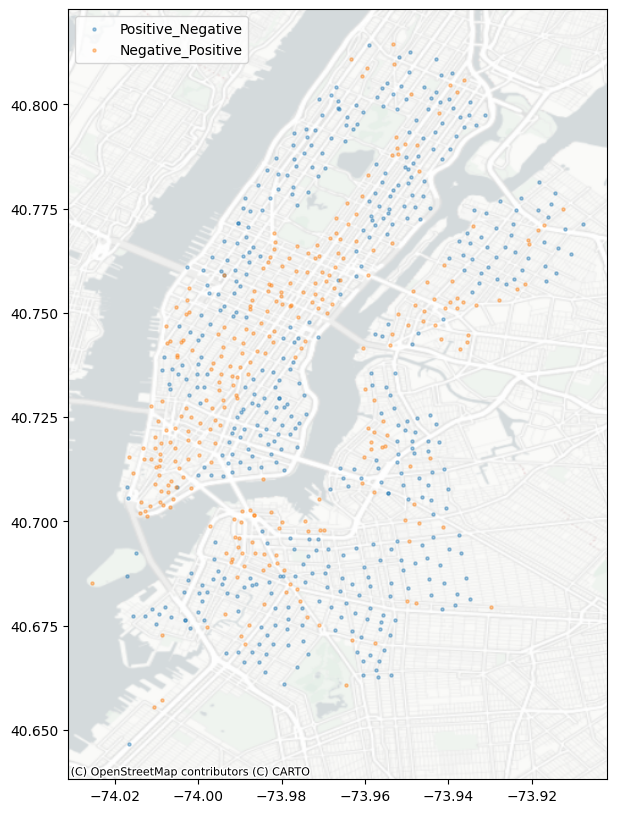

In [13]:
# plot with color for each full_demand_type
fig,ax=plt.subplots(figsize=(10,10))
for demand_type in ["Positive_Negative", "Negative_Positive"]:
    gdf_stations[gdf_stations['full_demand_type']==demand_type].plot(
        ax=ax,
        markersize=5,
        alpha=0.4,
        label=demand_type,
        aspect='equal'
    )

cx.add_basemap(ax, zoom=12, crs=gdf_stations.crs.to_string(),source=cx.providers.CartoDB.PositronNoLabels)
plt.legend()

Now we create the data for our classification model

In [14]:
labels = ["Positive_Negative", "Negative_Positive"]
X = gdf_stations[gdf_stations['full_demand_type'].isin(labels)][['latitude', 'longitude']].to_numpy()
y = gdf_stations[gdf_stations['full_demand_type'].isin(labels)]['full_demand_type'].apply(lambda x: 1 if x=="Positive_Negative" else 0).to_numpy()
X.shape, y.shape

((758, 2), (758,))

Converting it to kilometers and then normalizing it to make sure no feature dominates due to scale

In [15]:
# X to km
print(X)
latitude_conversion = 111  # km per degree latitude
longitude_conversion = 85   # km per degree longitude

X[:,0] = X[:,0] * latitude_conversion  # latitude to 1000 km
X[:,1] = X[:,1] * longitude_conversion   # longitude to 1000 km

# Normalize X
meanx = X[:,0].mean()
meany = X[:,1].mean()

X[:,0] = X[:,0] - meanx
X[:,1] = X[:,1] - meany
print(X)
print(meanx, meany)

[[ 40.76727216 -73.99392888]
 [ 40.71911552 -74.00666661]
 [ 40.71117416 -74.00016545]
 ...
 [ 40.72746421 -73.97950418]
 [ 40.76754878 -73.92093346]
 [ 40.68461654 -73.98721285]]
[[ 3.72654634 -1.91598157]
 [-1.6188407  -2.99868862]
 [-2.50033166 -2.44609002]
 ...
 [-0.69213645 -0.68988232]
 [ 3.75725116  4.28862953]
 [-5.4482276  -1.34511916]]
4521.4406634233255 -6287.567973226992


Spliiting into training and test sets

In [16]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Making the training and tuning loop

In [17]:

from sklearn.model_selection import GridSearchCV

models = {}
def grid_search_and_give_best_model(model, param_grid, models=models):
    grid_search = GridSearchCV(model, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(
        "Best parameters are {} \nScore : {}%".format(
            grid_search.best_params_, grid_search.best_score_*100)
    )
    models[model.__class__.__name__] = grid_search.best_score_*100
    return grid_search.best_estimator_

First trying a SVM model

In [18]:

from sklearn.svm import SVC


# define the parameter grid
param_grid = {'C': [1000, 10000, 100000, 1000000],
              'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]}

# perform grid search
svm = SVC(kernel='rbf')
best_SVM = grid_search_and_give_best_model(svm, param_grid)


Best parameters are {'C': 100000, 'gamma': 0.1} 
Score : 80.36303630363037%


Then trying neural network

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),  # input: longitude, latitude
    #Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')                   # binary output
])


# Compile the model
model.compile(
    optimizer='adam',
    loss=BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',      # what to monitor (val_loss or val_accuracy)
    patience=5,              # epochs to wait before stopping if no improvement
    restore_best_weights=True # roll back to the best weights
)


history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stop]
)

print(history.history['val_accuracy'])
models['NeuralNetwork'] = max(history.history['val_accuracy'])*100

c:\Users\anton\Documents\GitHub\Intro-to-Business-Analytics-project\.venv\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6136 - loss: 0.6621 - val_accuracy: 0.7131 - val_loss: 0.5997
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6405 - loss: 0.6383 - val_accuracy: 0.7459 - val_loss: 0.5943
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6322 - loss: 0.6395 - val_accuracy: 0.7131 - val_loss: 0.5958
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6446 - loss: 0.6366 - val_accuracy: 0.7049 - val_loss: 0.6004
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6384 - loss: 0.6307 - val_accuracy: 0.7377 - val_loss: 0.5901
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6405 - loss: 0.6302 - val_accuracy: 0.7377 - val_loss: 0.5883
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6446 - loss: 0.6301 - val_accuracy: 0.7131 - val_loss: 0.5977
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6343 - loss: 0.6308 - val_accuracy: 0.7377 - val_loss

Trying decision trees

In [20]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
                'min_samples_split': [2, 5, 10, 20, 50]}

dt = DecisionTreeClassifier()

best_DT = grid_search_and_give_best_model(dt, param_grid)
                              

Best parameters are {'max_depth': 14, 'min_samples_split': 2} 
Score : 77.06270627062706%


Trying random forests

In [21]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [25, 50, 100, 200, 400, 800],
                'max_depth': [5, 10, 15, 20, 25, 30]}

rf = RandomForestClassifier()

best_RF = grid_search_and_give_best_model(rf, param_grid)

Best parameters are {'max_depth': 20, 'n_estimators': 25} 
Score : 81.02310231023102%


Trying gradient boosting

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {'n_estimators': [25, 50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2, 0.3],
                'max_depth': [3, 5, 7, 9, 11]}
gb = GradientBoostingClassifier()
best_GB = grid_search_and_give_best_model(gb, param_grid)

Best parameters are {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100} 
Score : 81.02310231023102%


Trying Bagging Classifier

In [23]:
from sklearn.ensemble import BaggingClassifier

param_grid = {
    "n_estimators": [10, 50, 100, 200, 300, 400, 500],
    "max_samples": [0.5, 0.7, 1.0],
    "max_features": [1, 2],
}

bag = BaggingClassifier()

best_Bag = grid_search_and_give_best_model(bag, param_grid)

Best parameters are {'max_features': 2, 'max_samples': 1.0, 'n_estimators': 300} 
Score : 81.18811881188118%


Overview of the different models and their best accuracy

In [24]:
for model_name, accuracy in models.items():
    print(f"{model_name}: {accuracy:.2f}%")

SVC: 80.36%
NeuralNetwork: 77.05%
DecisionTreeClassifier: 77.06%
RandomForestClassifier: 81.02%
GradientBoostingClassifier: 81.02%
BaggingClassifier: 81.19%


Getting the final accuracy on the test set

Accuracy:  0.8355263157894737


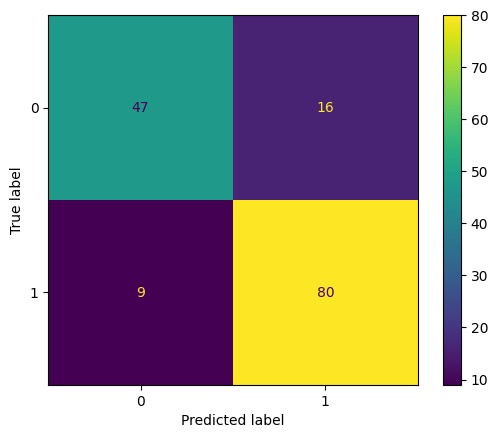

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

#choosing our best model
best_model = best_Bag

y_test_pred = best_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
display = ConfusionMatrixDisplay(cm)
display.plot()  
plt.show()


Getting accuracy score for all data points

Accuracy:  0.9670184696569921


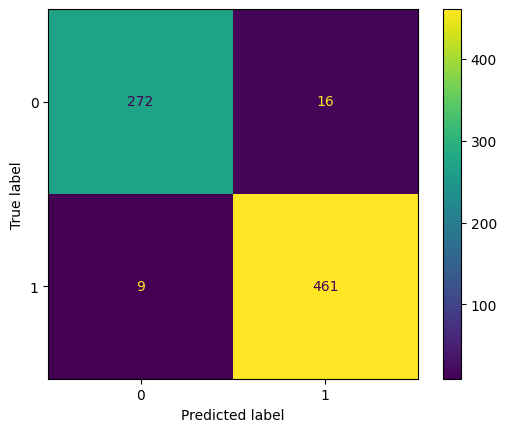

In [26]:
y_pred = best_model.predict(X)
print("Accuracy: ", accuracy_score(y, y_pred))

cm = confusion_matrix(y, y_pred)
display = ConfusionMatrixDisplay(cm)
display.plot()  
plt.show()


Making a mesh grid to plot the decision boundary

In [27]:
xx, yy = np.meshgrid(
        np.linspace(X[:,0].min()*1.1, X[:,0].max()*1.1, 1000),
        np.linspace(X[:,1].min()*1.1, X[:,1].max()*1.1, 1000)
    )

Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

pltxx = (xx + meanx) / latitude_conversion  # back to latitude
pltyy = (yy + meany) / longitude_conversion  # back to longitude

Plotting all the stations again on the map, colored by their actual net demand type

With a contour plot showing the decision boundary of our best model

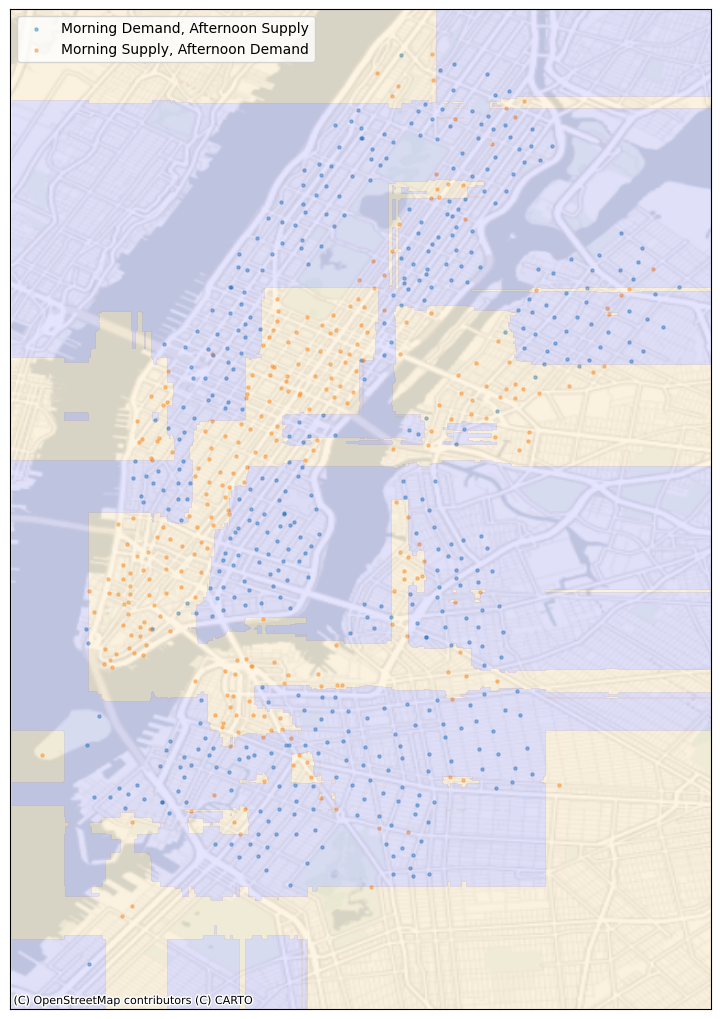

In [ ]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_axes([0, 0, 1, 1])

for demand_type, label in [("Positive_Negative", "Morning Demand, Afternoon Supply"), ("Negative_Positive", "Morning Supply, Afternoon Demand")]:
    gdf_stations[gdf_stations['full_demand_type']==demand_type].plot(
        ax=ax,
        markersize=5,
        alpha=0.4,
        label=label,
        aspect='equal'
    )

cx.add_basemap(ax, zoom=12, crs=gdf_stations.crs.to_string(),source=cx.providers.CartoDB.PositronNoLabels)

# add contour
plt.contourf(pltyy, pltxx, Z, alpha=0.1, levels=[-0.5, 0.5, 1.5], colors=['orange', 'blue'])
ax.set_yticks([])
ax.set_xticks([])
plt.legend()